In [96]:
import numpy as np
import copy

import neal

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit import Aer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp 

import rustworkx
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw

{'name': 'a', 'c': 1.6}
{'name': 'b', 'c': 3.2}
{'name': 'c', 'c': 0.6}
{'name': 'd', 'c': 3.8}
{'name': 'd', 'c': 2.8}


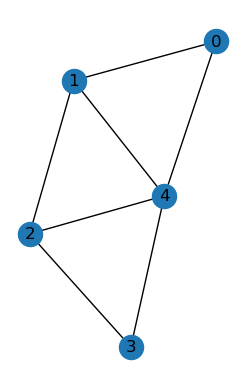

In [97]:
import rustworkx
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw

graph = rustworkx.PyGraph()

C = 2
D = 2

nodeDictionary = {
    ("a"):{"name":"a","f":0.8,"g":0},
    ("b"):{"name":"b","f":0.6,"g":1},
    ("c"):{"name":"c","f":0.3,"g":0},
    ("d"):{"name":"d","f":0.9,"g":1},
    ("e"):{"name":"d","f":0.4,"g":1}
}

new_node_dict = {node: {"name": attrs["name"], "c": C*attrs["f"] + D*attrs["g"]} 
                 for node, attrs in nodeDictionary.items()}
nodeDictionary = new_node_dict

edgeDictionary = {
    ("a","b"):{"cost":4},
    ("a","e"):{"cost":3},
    ("b","e"):{"cost":9},
    ("b","c"):{"cost":8},
    ("c","e"):{"cost":2},
    ("c","d"):{"cost":6},
    ("d","e"):{"cost":1}
}

indexDictionary = {
    "a":0,
    "b":1,
    "c":2,
    "d":3,
    "e":4
}

for node in nodeDictionary.items():
  graph.add_node(node[1])

for edge in edgeDictionary.items():
  graph.add_edge( indexDictionary[edge[0][0]] , indexDictionary[edge[0][1]] , edge[1]["cost"])
  
nodeIndices = graph.node_indices()
for i in range(len(nodeIndices)):
  print(graph[i])

subax1 = plt.subplot(121)
mpl_draw(graph, with_labels=True, ax=subax1)

In [98]:
####################################################################
#Formulating and solving a Hamiltonian from a given rustworkx graph#
####################################################################

from pyqubo import Binary
from pyqubo import Array
from pprint import pprint
import neal

#create an array of binary variables in our Hamiltonian. 
#x[i] = 1 if a sensor is placed at that node, 0 otherwise

x = Array.create('x', shape=(nodes), vartype='BINARY')

#####calculate H_1#####
H_1 = 0
weight_max = None 

for edge in graph.edge_list():
  weight = graph.get_edge_data(*edge)

  if weight_max is None or weight > weight_max:
    weight_max = weight

  H_1 += (1-x[edge[0]])*(1-x[edge[1]])*weight

H_1 *= 1/weight_max

#####calculate H_2#####
H_2 = 0

for i in range(len(nodeIndices)):
  cost = graph[i]["c"]
  H_2 += x[i]*cost

#####calculate H_3#####

#number of sensors we want
sensors = 2
H_3 = (sum(x)-sensors)**2

#####Get Hamiltonian function#####
A,B,C = 100,100,100 #random coef for now
H = A*H_1 + B*H_2 + C*H_3

#Compile the Hamiltonian to get a model
model = H.compile()

#get and print QUBO coefficients
qubo, offset = model.to_qubo()
#print("Printing QUBO coefficients:")
#pprint(qubo)

In [99]:
#D-Wave Simulator
#Solve BinaryQuadraticModel(BQM) by using Sampler class
bqm = model.to_bqm()

#get the solutions of QUBO as SampleSet
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=10)

#interpret the sampleset object
decoded_samples = model.decode_sampleset(sampleset)
#print the decoded_samples
#print("")
#print("Printing the decoded sample:")
#pprint(decoded_samples)

best_sample = min(decoded_samples, key=lambda x: x.energy)

#print the best sample
print("Printing the best sample:")
pprint(best_sample.sample)


Printing the best sample:
{'x[0]': 1, 'x[1]': 0, 'x[2]': 1, 'x[3]': 0, 'x[4]': 0}


In [89]:
print(qubo)
import math
i = 0
j = 0
n = len(qubo)

nodes = 5

qubo_ordered = []
used = []
for i in range(nodes):
  for j in range(nodes):
    check1 = 'x['+str(i)+']'
    check2 = 'x['+str(j)+']'
    if (check1, check2) in qubo and (check1, check2) not in used:
      qubo_ordered.append(qubo[(check1, check2)])
      #list.append((check1, check2))
      used.append((check1, check2))

    elif (check2,check1) in qubo and (check2,check1) not in used:
      #list.append((check2,check1))
      used.append((check2, check1))
      qubo_ordered.append(qubo[(check2,check1)])      
print(qubo_ordered)

{('x[0]', 'x[0]'): -217.77777777777777, ('x[4]', 'x[1]'): 300.0, ('x[2]', 'x[1]'): 288.8888888888889, ('x[1]', 'x[0]'): 244.44444444444446, ('x[4]', 'x[2]'): 222.22222222222223, ('x[3]', 'x[1]'): 200.0, ('x[4]', 'x[3]'): 211.11111111111111, ('x[3]', 'x[3]'): 2.2222222222222285, ('x[2]', 'x[2]'): -417.77777777777777, ('x[3]', 'x[2]'): 266.66666666666663, ('x[1]', 'x[1]'): -213.33333333333326, ('x[3]', 'x[0]'): 200.0, ('x[2]', 'x[0]'): 200.0, ('x[4]', 'x[4]'): -186.66666666666663, ('x[4]', 'x[0]'): 233.33333333333331}
[-217.77777777777777, 244.44444444444446, 200.0, 200.0, 233.33333333333331, -213.33333333333326, 288.8888888888889, 200.0, 300.0, -417.77777777777777, 266.66666666666663, 222.22222222222223, 2.2222222222222285, 211.11111111111111, -186.66666666666663]


In [90]:
weights = qubo_ordered


In [91]:
def create_problem(weights:np.array, nodes) -> QuadraticProgram:
    total: int = 3
    iterations = int(nodes*0.5*nodes)
    result = []
    mdl = Model()
    dummy = 0
    x = [mdl.binary_var("x%s" % i) for i in range(nodes)]
    used = []
    for i in range(nodes):
        for j in range(nodes):
            if (i,j) not in used and (j,i) not in used:
                result.append(x[i]*x[j])
                used.append((i,j))
    new_result = []
    for i in range(len(result)):
        new_result.append(weights[i]*result[i])

    objective = mdl.sum(new_result)
    mdl.minimize(objective)
    cost = (mdl.sum(x))
    #mdl.add_constraint(cost == total)

    qp = from_docplex_mp(mdl)
    return qp

weights = qubo_ordered
weights2 = [1, -2, -3, 4, 5, -6]

qubo = create_problem(weights, nodes)
print(qubo.prettyprint())


Problem name: docplex_model26

Minimize
  -217.77777777777777*x0^2 + 244.44444444444446*x0*x1 + 200*x0*x2 + 200*x0*x3
  + 233.33333333333331*x0*x4 - 213.33333333333326*x1^2 + 288.8888888888889*x1*x2
  + 200*x1*x3 + 300*x1*x4 - 417.77777777777777*x2^2 + 266.66666666666663*x2*x3
  + 222.22222222222223*x2*x4 + 2.2222222222222285*x3^2
  + 211.11111111111111*x3*x4 - 186.66666666666663*x4^2

Subject to
  No constraints

  Binary variables (5)
    x0 x1 x2 x3 x4



In [92]:
result = CplexOptimizer().solve(qubo)
print(result.prettyprint())

objective function value: -435.55555555555554
variable values: x0=1.0, x1=0.0, x2=1.0, x3=0.0, x4=0.0
status: SUCCESS


In [93]:
algorithm_globals.random_seed = 12345

sampler = Aer.get_backend('aer_simulator')

qaoa_mes = QAOA(optimizer=COBYLA(), initial_point=[0.0, 1.0], quantum_instance=sampler)
exact_mes = NumPyMinimumEigensolver()

qaoa = MinimumEigenOptimizer(qaoa_mes)

qaoa_result = qaoa.solve(qubo)

print(qaoa_result)

fval=-435.55555555555554, x0=1.0, x1=0.0, x2=1.0, x3=0.0, x4=0.0, status=SUCCESS
